In [ ]:
!pip install neo4j
!pip install -U langchain-community
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
from neo4j import GraphDatabase

uri = "neo4j+s://be3b0aee.databases.neo4j.io"
username = "neo4j"
password = "tW3xXP-LILuTfVA-vZkiFxh4EAmil8HQ0HcF5-7kBvo"

driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

try:
    result = session.run("RETURN 'Connection successful!'")
    print(result.single()[0])  # Should print: 'Connection successful!'
except Exception as e:
    print(f"Error: {e}")
finally:
    session.close()

Connection successful!


In [ ]:
from neo4j import GraphDatabase  # Neo4j connection using the official Neo4j Python driver
from langchain.document_loaders import PyPDFLoader  # PDF loader to extract document content
import re

# Step 1: Load the PDF document
pdf_path = "/content/job_market_report.pdf"  # Replace with the path to your PDF file
loader = PyPDFLoader(pdf_path)
documents = loader.load()  # Load the document

# Step 2: Extract text from the document (this could be used to create nodes)
if not documents:
    print("No documents found.")
else:
    pdf_content = documents[0].page_content  # Getting the content from the first page

    # Optional: Split the content into paragraphs (or sections) to create different nodes
    paragraphs = re.split(r'\n+', pdf_content)  # Split by new lines (you could adjust the split method)
    paragraphs = [p.strip() for p in paragraphs if p.strip()]  # Clean empty paragraphs

# Step 3: Set up Neo4j connection using official driver
uri = "neo4j+s://be3b0aee.databases.neo4j.io"  # Your Neo4j URI
username = "neo4j"  # Your Neo4j username
password = "tW3xXP-LILuTfVA-vZkiFxh4EAmil8HQ0HcF5-7kBvo"  # Your Neo4j password

# Create a Neo4j driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Step 4: Function to create nodes in Neo4j
def create_node(session, paragraph, index):
    query = f"""
    CREATE (p:Paragraph {{
        content: $content,
        index: $index
    }})
    """
    session.run(query, content=paragraph, index=index)

# Step 5: Add the content to Neo4j as nodes
with driver.session() as session:
    for idx, paragraph in enumerate(paragraphs):
        create_node(session, paragraph, idx)

# Step 6: Optionally, create relationships (e.g., linking paragraphs)
with driver.session() as session:
    for i in range(1, len(paragraphs)):
        query = """
        MATCH (a:Paragraph), (b:Paragraph)
        WHERE a.index = $start_index AND b.index = $end_index
        CREATE (a)-[:FOLLOWS]->(b)
        """
        session.run(query, start_index=i-1, end_index=i)

print("PDF content has been successfully added to Neo4j.")


PDF content has been successfully added to Neo4j.


<ipython-input-10-94eabd7a13ec>:32: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_node(start_node.id, label=start_content, node_type="start")
<ipython-input-10-94eabd7a13ec>:33: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_node(end_node.id, label=end_content, node_type="end")
<ipython-input-10-94eabd7a13ec>:36: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_edge(start_node.id, end_node.id, type=relationship.type)


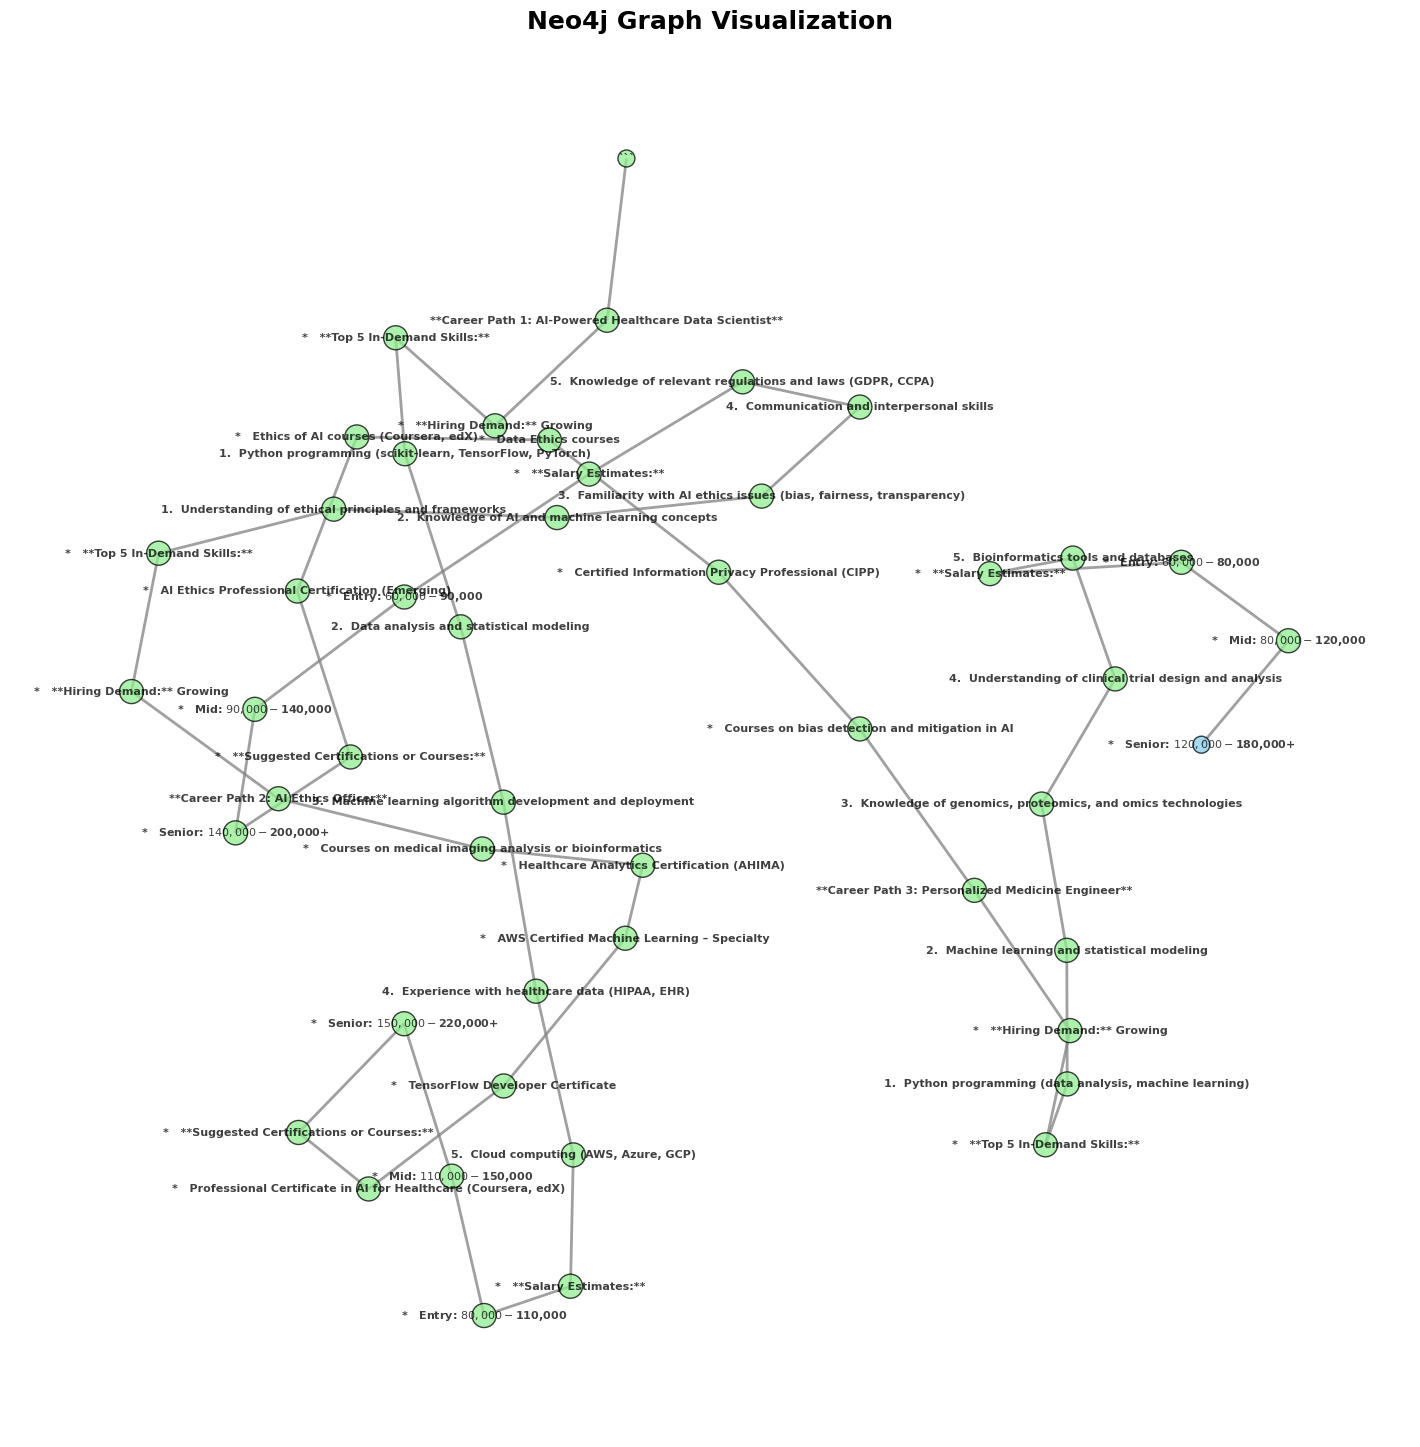

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

# Default Cypher query
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"

def showGraph(cypher: str = default_cypher):
    # Create a Neo4j session to run queries
    driver = GraphDatabase.driver(
        uri="neo4j+s://be3b0aee.databases.neo4j.io",  # Replace with your actual Neo4j URI
        auth=("neo4j", "tW3xXP-LILuTfVA-vZkiFxh4EAmil8HQ0HcF5-7kBvo")  # Replace with your actual username and password
    )

    with driver.session() as session:
        result = session.run(cypher)

        # Create a NetworkX graph object
        G = nx.Graph()

        # Process the results and add nodes and relationships
        for record in result:
            start_node = record["s"]
            end_node = record["t"]
            relationship = record["r"]

            # Add nodes to the graph with content as the label
            start_content = start_node["content"] if "content" in start_node else f"Node {start_node.id}"
            end_content = end_node["content"] if "content" in end_node else f"Node {end_node.id}"

            # Add nodes with a unique identifier and label
            G.add_node(start_node.id, label=start_content, node_type="start")
            G.add_node(end_node.id, label=end_content, node_type="end")

            # Add relationship to the graph (as an edge between nodes)
            G.add_edge(start_node.id, end_node.id, type=relationship.type)

        # Create a layout for the nodes
        pos = nx.spring_layout(G, seed=42, k=0.15, iterations=20)

        # Create custom node colors based on type (you can add more conditions for node types)
        node_colors = ['lightgreen' if G.nodes[node]["node_type"] == "start" else 'skyblue' for node in G.nodes]

        # Create custom edge colors based on relationship type
        edge_colors = ['orange' if G[u][v]['type'] == 'MENTIONS' else 'gray' for u, v in G.edges]

        # Customize node sizes based on degree (node connectivity)
        node_sizes = [len(list(G.neighbors(node))) * 150 for node in G.nodes]  # Adjusted node size

        # Draw the graph with the node labels as content
        plt.figure(figsize=(14, 14))
        nx.draw(G, pos,
                with_labels=True,
                labels=nx.get_node_attributes(G, 'label'),
                node_size=node_sizes,
                node_color=node_colors,
                font_size=8,  # Reduced font size
                font_weight='bold',
                edge_color=edge_colors,
                width=2,
                alpha=0.75,
                style='solid',  # Solid edges for better visibility
                edgecolors='black')  # Black border around nodes

        # Set title and other formatting options
        plt.title("Neo4j Graph Visualization", fontsize=18, fontweight='bold')
        plt.axis('off')  # Turn off the axis

        # Show the graph
        plt.show()

# Call the function to visualize the graph
showGraph()
